# A 5-minute Quick Start with LSDB/HiPSCat

**Authors**: Neven Caplar, Mario Juric, and the LINCC team \
Derived from the notebooks at https://github.com/lincc-frameworks/Rare_Gems_Demo

### Demo preparation

These are here to make the plots pretty for this demo (a typical user wouldn't need to do this).

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import rcParams

# Jupyter-specific settings and magic commands
%matplotlib inline
%config InlineBackend.figure_format = "retina"

# Configuration settings
rcParams['savefig.dpi'] = 550
rcParams['font.size'] = 20
plt.rc('font', family='serif')
mpl.rcParams['axes.linewidth'] = 2

# Disable some pesky warnings for this demo. DO NOT DO THIS IN PRODUCTION!
import warnings
warnings.filterwarnings("ignore")

# Format introspection utilities
from hipscat.inspection import plot_pixels

### Importing LSDB packages

This is what a typical user would start with:

In [2]:
# Local library-specific imports
import lsdb

print(f'Version of lsdb is {lsdb.__version__}')

Version of lsdb is 0.2.3


## The Catalogs

The catalogs LSDB is designed to manipulate are stored in the partitioned HiPSCat format. LSDB knows to read any source that [fsspec](https://filesystem-spec.readthedocs.io/en/latest/) can read. In particular, this also includes simple HTTP websites -- **anyone can share new catalogs by simply making them accessible via HTTP** (no complicated server infrastructure is required).

Here, we'll use a few catalogs we've made available at https://data.lsdb.io:

In [ ]:
# import fsspec, os
# fsspec.config.conf['simplecache'] = {'cache_storage': os.getcwd() + '/cache'}

In [5]:
base_url = "https://data.lsdb.io/unstable"

gaia_url = f"{base_url}/gaia_dr3/gaia"
ztf_object_url = f"{base_url}/ztf/ztf_dr14"
ztf_source_url = f"{base_url}/ztf/ztf_zource"

print(gaia_url)
print(ztf_object_url)
print(ztf_source_url)

https://data.lsdb.io/unstable/gaia_dr3/gaia
https://data.lsdb.io/unstable/ztf/ztf_dr14
https://data.lsdb.io/unstable/ztf/ztf_zource


## Accessing the Catalogs, and Introducing Lazy Operations

When working with large datasets, there is too much data to be loaded into memory at once. To get around this, LSDB uses the HiPSCat format which partitions a catalog into HEALPix cells and works on one partition at a time. This also allows the computation to be parallelized to work on multiple partitions at once. In order to efficiently carry out pipelines of operations though, it's better to batch operations so that multiple operations can be done back to back on the same partition instead of having to load and save each partition from storage after every operation.

For this reason, operations in LSDB are performed 'lazily'. This means when a catalog is read using `read_hipscat`, the actual catalog data isn't being read from storage. Instead, it only loads the metadata such as the column schema and the HEALPix structure of the partitions. When an operation like `cone_search` is called on a catalog, the data is not actually loaded and operated on when the line of code is executed. Instead, the catalog keeps track of the operations that it needs to perform so the entire pipeline can be efficiently run later. This also allows us to optimize the pipeline by only loading the partitions that are necessary. For example when performing a cone search like we do here, we only need the partitions that have data within the cone.

So when we look at a catalog that has been lazy loaded we see the DataFrame without the data, just the columns and the number of partitions (including the HiPSCat index of each partition encoding which HEALPix cell the partition is in). 

In [4]:
%%time

# Instantiate the lazy data-frame object for the Gaia catalog
gaia = lsdb.read_hipscat(gaia_url)

gaia

IndexError: list index out of range

This only loaded the metadata; no loading of data has happened yet. For that, we'd need to run:

```
df = gaia.compute()
```

, which would quickly exhaust all of our RAM. So let's **chain** the `read_hipscat` command with a `cone_search`.

In [5]:
%%time

# Instantiate the data-frame like Gaia catalog object for data within ~1 deg cone in the sky
gaia = lsdb.read_hipscat(gaia_url).cone_search(ra=-60, dec=20.5, radius_arcsec=1*3600)

gaia

CPU times: user 579 ms, sys: 154 ms, total: 733 ms
Wall time: 10.6 s


Dask DataFrame Structure:
                         solution_id      designation       source_id    random_index        ref_epoch               ra         ra_error              dec        dec_error         parallax   parallax_error parallax_over_error               pm             pmra       pmra_error            pmdec      pmdec_error      ra_dec_corr ra_parallax_corr     ra_pmra_corr    ra_pmdec_corr dec_parallax_corr    dec_pmra_corr   dec_pmdec_corr parallax_pmra_corr parallax_pmdec_corr  pmra_pmdec_corr astrometric_n_obs_al astrometric_n_obs_ac astrometric_n_good_obs_al astrometric_n_bad_obs_al astrometric_gof_al astrometric_chi2_al astrometric_excess_noise astrometric_excess_noise_sig astrometric_params_solved astrometric_primary_flag nu_eff_used_in_astrometry     pseudocolour pseudocolour_error ra_pseudocolour_corr dec_pseudocolour_corr parallax_pseudocolour_corr pmra_pseudocolour_corr pmdec_pseudocolour_corr astrometric_matched_transits visibility_periods_used astrometric_sigma5d_max matched_transits new_matched_transits matched_transits_removed ipd_gof_harmonic_amplitude ipd_gof_harmonic_phase ipd_frac_multi_peak ipd_frac_odd_win             ruwe scan_direction_strength_k1 scan_direction_strength_k2 scan_direction_strength_k3 scan_direction_strength_k4 scan_direction_mean_k1 scan_direction_mean_k2 scan_direction_mean_k3 scan_direction_mean_k4 duplicated_source    phot_g_n_obs phot_g_mean_flux phot_g_mean_flux_error phot_g_mean_flux_over_error  phot_g_mean_mag   phot_bp_n_obs phot_bp_mean_flux phot_bp_mean_flux_error phot_bp_mean_flux_over_error phot_bp_mean_mag   phot_rp_n_obs phot_rp_mean_flux phot_rp_mean_flux_error phot_rp_mean_flux_over_error phot_rp_mean_mag phot_bp_rp_excess_factor phot_bp_n_contaminated_transits phot_bp_n_blended_transits phot_rp_n_contaminated_transits phot_rp_n_blended_transits   phot_proc_mode            bp_rp             bp_g             g_rp  radial_velocity radial_velocity_error   rv_method_used   rv_nb_transits rv_nb_deblended_transits rv_visibility_periods_used rv_expected_sig_to_noise rv_renormalised_gof  rv_chisq_pvalue rv_time_duration rv_amplitude_robust rv_template_teff rv_template_logg rv_template_fe_h rv_atm_param_origin           vbroad     vbroad_error vbroad_nb_transits         grvs_mag   grvs_mag_error grvs_mag_nb_transits rvs_spec_sig_to_noise phot_variable_flag                l                b          ecl_lon          ecl_lat in_qso_candidates in_galaxy_candidates non_single_star has_xp_continuous has_xp_sampled        has_rvs has_epoch_photometry   has_epoch_rv has_mcmc_gspphot   has_mcmc_msc in_andromeda_survey classprob_dsc_combmod_quasar classprob_dsc_combmod_galaxy classprob_dsc_combmod_star     teff_gspphot teff_gspphot_lower teff_gspphot_upper     logg_gspphot logg_gspphot_lower logg_gspphot_upper       mh_gspphot mh_gspphot_lower mh_gspphot_upper distance_gspphot distance_gspphot_lower distance_gspphot_upper    azero_gspphot azero_gspphot_lower azero_gspphot_upper       ag_gspphot ag_gspphot_lower ag_gspphot_upper ebpminrp_gspphot ebpminrp_gspphot_lower ebpminrp_gspphot_upper  libname_gspphot          Norder              Dir             Npix
npartitions=4                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

To load the data and perform the operations, call `compute()` which will load the necessary data and perform all the operations that have been called, and return a Pandas DataFrame with the results.

In [6]:
%%time
df = gaia.compute()

df

CPU times: user 17.2 s, sys: 23.4 s, total: 40.6 s
Wall time: 5min 32s


solution_id                   designation  \
_hipscat_index                                                           
3646064119989141504  1636148068921376768  Gaia DR3 1823032030259465600   
3646067005166977024  1636148068921376768  Gaia DR3 1823033469045425664   
3646067005322166272  1636148068921376768  Gaia DR3 1823033473349390976   
3646067036225798144  1636148068921376768  Gaia DR3 1823033507709110400   
3646067036804612096  1636148068921376768  Gaia DR3 1823033507709111680   
...                                  ...                           ...   
3653836065044692992  1636148068921376768  Gaia DR3 1826918013561341952   
3653836065845805056  1636148068921376768  Gaia DR3 1826918009265256192   
3653836066403647488  1636148068921376768  Gaia DR3 1826918013566659840   
3653836070195298304  1636148068921376768  Gaia DR3 1826918009265256064   
3653836157197746176  1636148068921376768  Gaia DR3 1826918082280836480   

                               source_id  random_index  ref_epoch          ra  \
_hipscat_index                                                                  
3646064119989141504  1823032030259465600     865143729     2016.0     300.323   
3646067005166977024  1823033469045425664     834482168     2016.0  300.354463   
3646067005322166272  1823033473349390976    1312261049     2016.0  300.353417   
3646067036225798144  1823033507709110400    1622459167     2016.0  300.336424   
3646067036804612096  1823033507709111680    1115731789     2016.0  300.336033   
...                                  ...           ...        ...         ...   
3653836065044692992  1826918013561341952     719536941     2016.0  300.117206   
3653836065845805056  1826918009265256192    1328904095     2016.0  300.119462   
3653836066403647488  1826918013566659840     763877294     2016.0  300.118743   
3653836070195298304  1826918009265256064    1475860536     2016.0  300.124771   
3653836157197746176  1826918082280836480     558675004     2016.0  300.114821   

                     ra_error        dec  dec_error  parallax  ...  \
_hipscat_index                                                 ...   
3646064119989141504  0.022445   19.54927   0.021386  0.210155  ...   
3646067005166977024  0.242294  19.558069   0.240356  0.491425  ...   
3646067005322166272  0.329953  19.558007   0.305832  0.340153  ...   
3646067036225798144  0.228589  19.551617   0.222584  0.256528  ...   
3646067036804612096  0.559763  19.552258   0.509804  0.233862  ...   
...                       ...        ...        ...       ...  ...   
3653836065044692992  1.157871  21.493197   1.503138  1.777199  ...   
3653836065845805056  0.342659  21.492589   0.346808 -1.152616  ...   
3653836066403647488  2.490636  21.493434   1.846567      <NA>  ...   
3653836070195298304  0.240717   21.49295   0.230087  0.019161  ...   
3653836157197746176   0.74994  21.494043   0.739254  0.505036  ...   

                     ag_gspphot  ag_gspphot_lower  ag_gspphot_upper  \
_hipscat_index                                                        
3646064119989141504      1.1821             1.173            1.1908   
3646067005166977024        <NA>              <NA>              <NA>   
3646067005322166272        <NA>              <NA>              <NA>   
3646067036225798144        <NA>              <NA>              <NA>   
3646067036804612096        <NA>              <NA>              <NA>   
...                         ...               ...               ...   
3653836065044692992        <NA>              <NA>              <NA>   
3653836065845805056        <NA>              <NA>              <NA>   
3653836066403647488        <NA>              <NA>              <NA>   
3653836070195298304        <NA>              <NA>              <NA>   
3653836157197746176        <NA>              <NA>              <NA>   

                     ebpminrp_gspphot  ebpminrp_gspphot_lower  \
_hipscat_index                                                  
3646064119989141504            0.6328          

## Very Large Catalogs and HiPSCat Partitioning

To make it easier and more efficient to perform operations in parallel, HiPSCat partitions contain roughly the same number of rows. This is done by using different HEALPix pixel sizes for different parts of the sky depending on the density of sources. This means catalogs with more rows will have smaller pixels for each partition, and so will have more partitions overall. We can see this below with the ZTF object and source catalogs, where the source catalog with many more data points has more partitions to keep the size of each partition consistent.

In [7]:
%%time
ztf_object = lsdb.read_hipscat(ztf_object_url, columns=["ra", "dec"]) # ZTF Object
ztf_source = lsdb.read_hipscat(ztf_source_url, columns=["ra", "dec"]) # ZTF Source

CPU times: user 2.01 s, sys: 578 ms, total: 2.59 s
Wall time: 28.6 s


These really *are* large catalog:

In [8]:
print(f"{ztf_object.hc_structure.catalog_info.total_rows=:16,d} rows")
print(f"{ztf_source.hc_structure.catalog_info.total_rows=:16,d} rows")

ztf_object.hc_structure.catalog_info.total_rows=   1,234,463,018 rows
ztf_source.hc_structure.catalog_info.total_rows= 570,809,800,013 rows


Let's look at the number of partitions:

In [9]:
print(f"{ztf_object._ddf.npartitions=:9,d} partitions")
print(f"{ztf_source._ddf.npartitions=:9,d} partitions")

ztf_object._ddf.npartitions=    2,352 partitions
ztf_source._ddf.npartitions=   41,679 partitions


Let's visualize them:

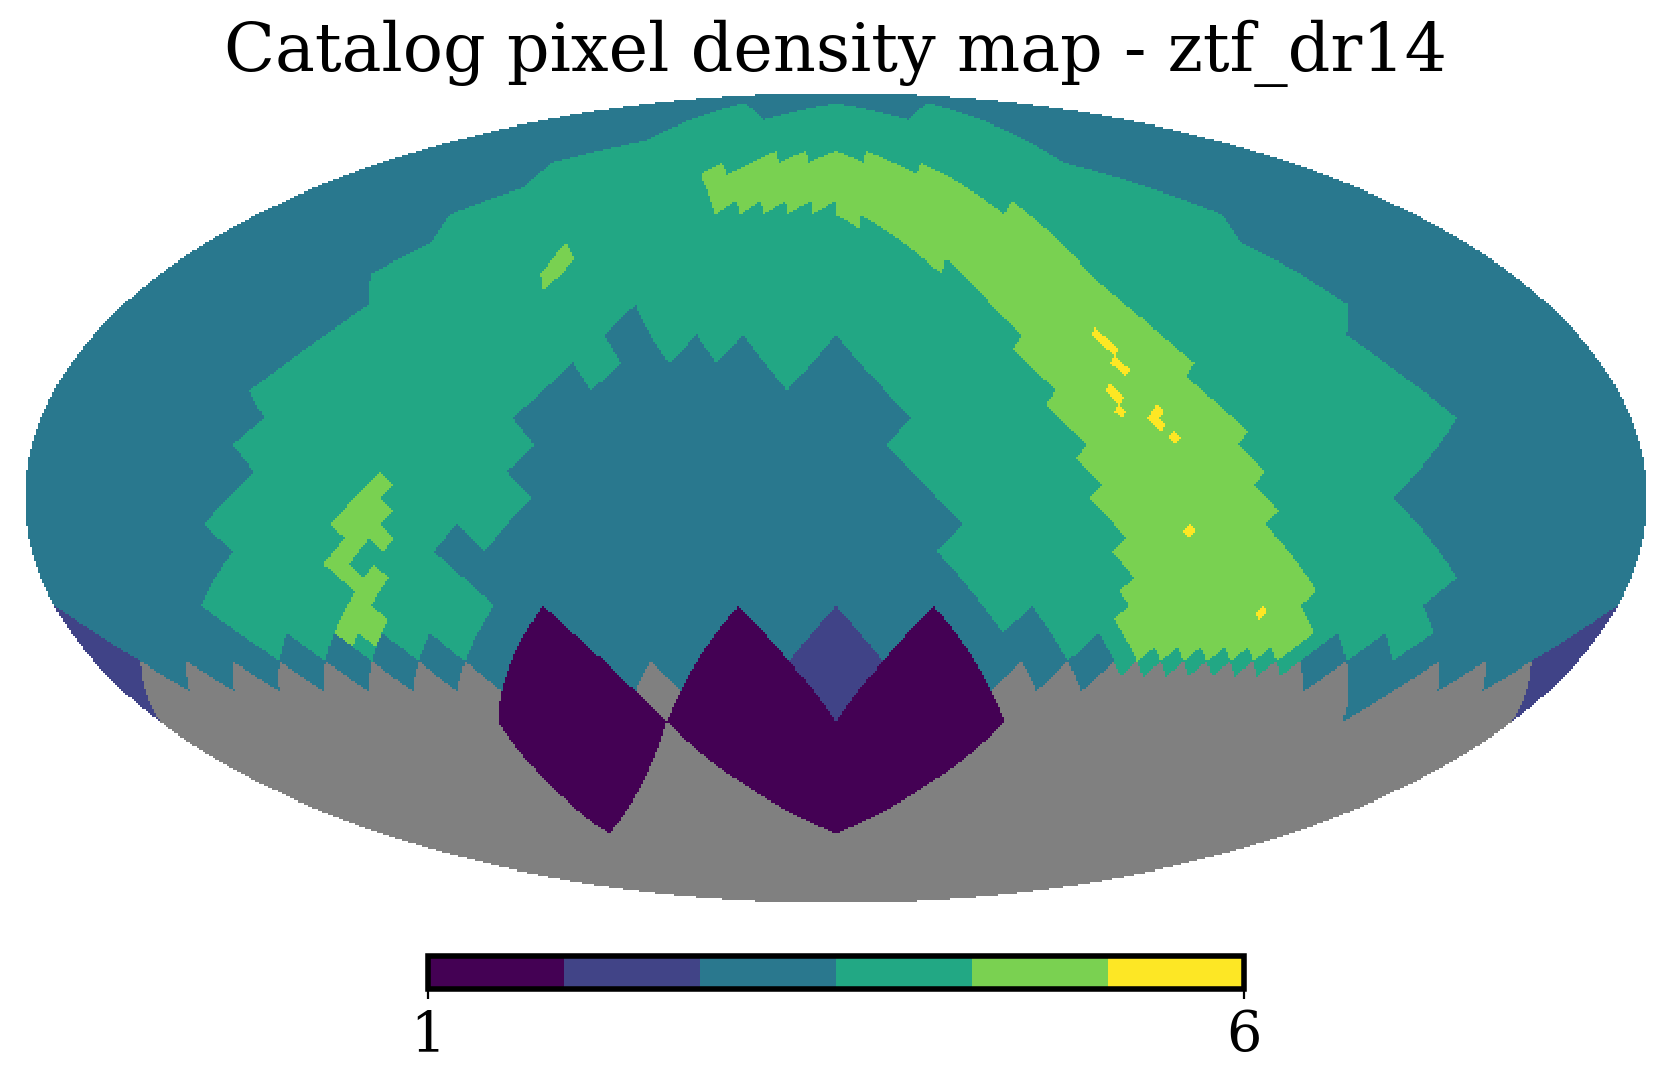

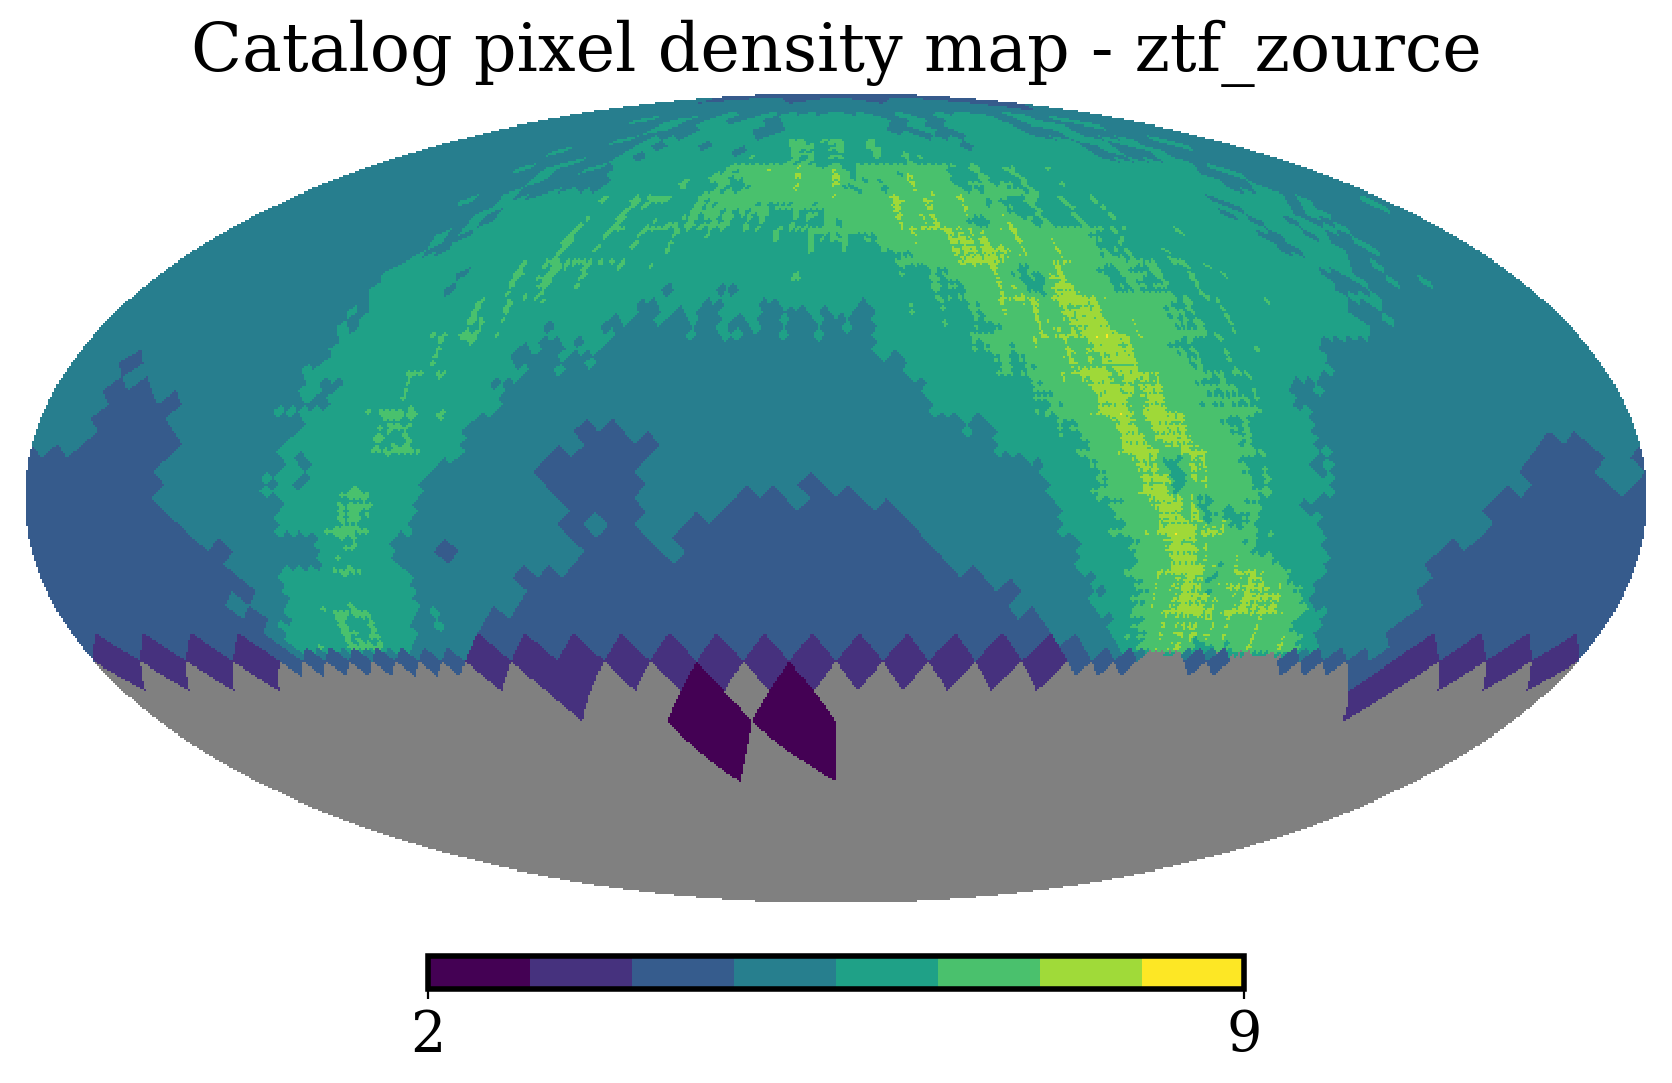

In [10]:
# Plot the Pixel Density Maps for Gaia and ZTF
plot_pixels(ztf_object.hc_structure)
plot_pixels(ztf_source.hc_structure)

## Cross-matching of HiPSCat catalogs

Positional cross-matching is as simple as running `catL.crossmatch(catR)`.

For large operations we might want to see a small subset of the computed final data without doing the full computation. Like pandas, we can use the `head` operation to compute the first n rows of the final dataframe without computing the whole dataset.

In [11]:
%%time 
gaia.crossmatch(ztf_object).head(5)

CPU times: user 6.2 s, sys: 6.56 s, total: 12.8 s
Wall time: 2min 11s


solution_id_gaia              designation_gaia  \
_hipscat_index                                                           
3646064119989141504  1636148068921376768  Gaia DR3 1823032030259465600   
3646067005166977024  1636148068921376768  Gaia DR3 1823033469045425664   
3646067005322166272  1636148068921376768  Gaia DR3 1823033473349390976   
3646067036225798144  1636148068921376768  Gaia DR3 1823033507709110400   
3646067039711264768  1636148068921376768  Gaia DR3 1823033507728217600   

                          source_id_gaia  random_index_gaia  ref_epoch_gaia  \
_hipscat_index                                                                
3646064119989141504  1823032030259465600          865143729          2016.0   
3646067005166977024  1823033469045425664          834482168          2016.0   
3646067005322166272  1823033473349390976         1312261049          2016.0   
3646067036225798144  1823033507709110400         1622459167          2016.0   
3646067039711264768  1823033507728217600         1016028102          2016.0   

                        ra_gaia  ra_error_gaia   dec_gaia  dec_error_gaia  \
_hipscat_index                                                              
3646064119989141504     300.323       0.022445   19.54927        0.021386   
3646067005166977024  300.354463       0.242294  19.558069        0.240356   
3646067005322166272  300.353417       0.329953  19.558007        0.305832   
3646067036225798144  300.336424       0.228589  19.551617        0.222584   
3646067039711264768  300.336573       0.036651  19.552868        0.035308   

                     parallax_gaia  ...  ebpminrp_gspphot_gaia  \
_hipscat_index                      ...                          
3646064119989141504       0.210155  ...                 0.6328   
3646067005166977024       0.491425  ...                   <NA>   
3646067005322166272       0.340153  ...                   <NA>   
3646067036225798144       0.256528  ...                   <NA>   
3646067039711264768       0.113244  ...                 0.6735   

                     ebpminrp_gspphot_lower_gaia  ebpminrp_gspphot_upper_gaia  \
_hipscat_index                                                                  
3646064119989141504                       0.6277                       0.6375   
3646067005166977024                         <NA>                         <NA>   
3646067005322166272                         <NA>                         <NA>   
3646067036225798144                         <NA>                         <NA>   
3646067039711264768                       0.6641                       0.6858   

                     libname_gspphot_gaia  Norder_gaia  Dir_gaia  Npix_gaia  \
_hipscat_index                                                                
3646064119989141504                 MARCS            5         0       3238   
3646067005166977024                  <NA>            5         0       3238   
3646067005322166272                  <NA>            5         0       3238   
3646067036225798144                  <NA>            5         0       3238   
3646067039711264768               PHOENIX            5         0       3238   

                     ra_ztf_dr14  dec_ztf_dr14  _dist_arcsec  
_hipscat_index                                                
3646064119989141504   300.322998     19.549284      0.050271  
3646067005166977024   300.354462     19.558081      0.043431  
3646067005322166272   300.353401     19.558013      0.058879  
3646067036225798144   300.336411     19.551633      0.072412  
3646067039711264768   300.336571     19.552879      0.039042  

[5 rows x 158 columns]

## A (slightly) more involved science example

Let's load a subset of Gaia, join it with ZTF (using a nearest-neighbor cross-match as the JOIN predicate), and run a query against the joined table.

In [12]:
%%time
ztf_object_full = lsdb.read_hipscat(ztf_object_url)

# crossmatch ZTF + Gaia
xobjects = (
        gaia.crossmatch(ztf_object_full)
            .query(""" \
                nobs_g_ztf_dr14 > 50 and nobs_r_ztf_dr14 > 50 and \
                parallax_gaia > 0 and parallax_over_error_gaia > 5 and \
                teff_gspphot_gaia > 5380 and teff_gspphot_gaia < 7220 and logg_gspphot_gaia > 4.5 \
                and logg_gspphot_gaia < 4.72 and classprob_dsc_combmod_star_gaia > 0.5 \
                """)
)

CPU times: user 493 ms, sys: 133 ms, total: 626 ms
Wall time: 11.8 s


Nothing ran yet; only the execution graph has been constructed. The `.compute()` call will execute it (materialize the result):

In [13]:
%%time
df = xobjects.compute()
df

CPU times: user 21.3 s, sys: 25.3 s, total: 46.6 s
Wall time: 5min 39s


solution_id_gaia              designation_gaia  \
_hipscat_index                                                           
3646067079259357184  1636148068921376768  Gaia DR3 1823033542087957248   
3646067849677504512  1636148068921376768  Gaia DR3 1823033920045097728   
3646068328969011200  1636148068921376768  Gaia DR3 1823034156246247424   
3646079368708489216  1636148068921376768  Gaia DR3 1823039658126194176   
3646079377201954816  1636148068921376768  Gaia DR3 1823039692480622976   
...                                  ...                           ...   
3653829094635732992  1636148068921376768  Gaia DR3 1826914543258245888   
3653829228861849600  1636148068921376768  Gaia DR3 1826914611977691264   
3653829247430033408  1636148068921376768  Gaia DR3 1826914611977688704   
3653829567539314688  1636148068921376768  Gaia DR3 1826914783776458624   
3653835666741002240  1636148068921376768  Gaia DR3 1826917807433482752   

                          source_id_gaia  random_index_gaia  ref_epoch_gaia  \
_hipscat_index                                                                
3646067079259357184  1823033542087957248          681413300          2016.0   
3646067849677504512  1823033920045097728          606871238          2016.0   
3646068328969011200  1823034156246247424          987360779          2016.0   
3646079368708489216  1823039658126194176         1633982299          2016.0   
3646079377201954816  1823039692480622976          367753372          2016.0   
...                                  ...                ...             ...   
3653829094635732992  1826914543258245888         1528507267          2016.0   
3653829228861849600  1826914611977691264         1690142768          2016.0   
3653829247430033408  1826914611977688704          996564350          2016.0   
3653829567539314688  1826914783776458624         1445282743          2016.0   
3653835666741002240  1826917807433482752          832277656          2016.0   

                        ra_gaia  ra_error_gaia   dec_gaia  dec_error_gaia  \
_hipscat_index                                                              
3646067079259357184  300.344658       0.028663  19.554414        0.027776   
3646067849677504512  300.426663       0.014488  19.587297        0.014479   
3646068328969011200  300.422159       0.042693  19.608572        0.041722   
3646079368708489216  300.549673       0.041812  19.653736        0.039993   
3646079377201954816    300.5315       0.037491  19.641191        0.035262   
...                         ...            ...        ...             ...   
3653829094635732992  300.190156        0.03939  21.451042        0.039384   
3653829228861849600  300.222469       0.036843  21.458198        0.039499   
3653829247430033408  300.229901       0.015495  21.465304        0.016096   
3653829567539314688  300.154678       0.031628  21.454938        0.034043   
3653835666741002240  300.133704       0.035317  21.486115        0.038298   

                     parallax_gaia  ...  nobs_g_ztf_dr14  nobs_r_ztf_dr14  \
_hipscat_index                      ...                                     
3646067079259357184       0.668537  ...              404             1009   
3646067849677504512        0.97283  ...              101              373   
3646068328969011200       0.350765  ...               94              362   
3646079368708489216       0.485155  ...              352              953   
3646079377201954816       0.380807  ...              396             1008   
...                            ...  ...              ...              ...   
3653829094635732992       0.311161  ...              398             1000   
3653829228861849600       0.474479  ...              376              953   
3653829247430033408       1.378988  ...              404             1004   
3653829567539314688       0.472456  ...              352              968   
3653835666741002240       0.499131  ...              352              948   

                     nobs_i_z

Let us now visualize the GAIA object that got matched and the all of the starting GAIA matches. We'll use a loading trick to display the underlying partitions in which GAIA data is stored. Red circle (approximately) shows the Cone in which we conducted the cross-match. Note the patch where there are no cross-matches - because this is a gap in the ZTF coverage. 

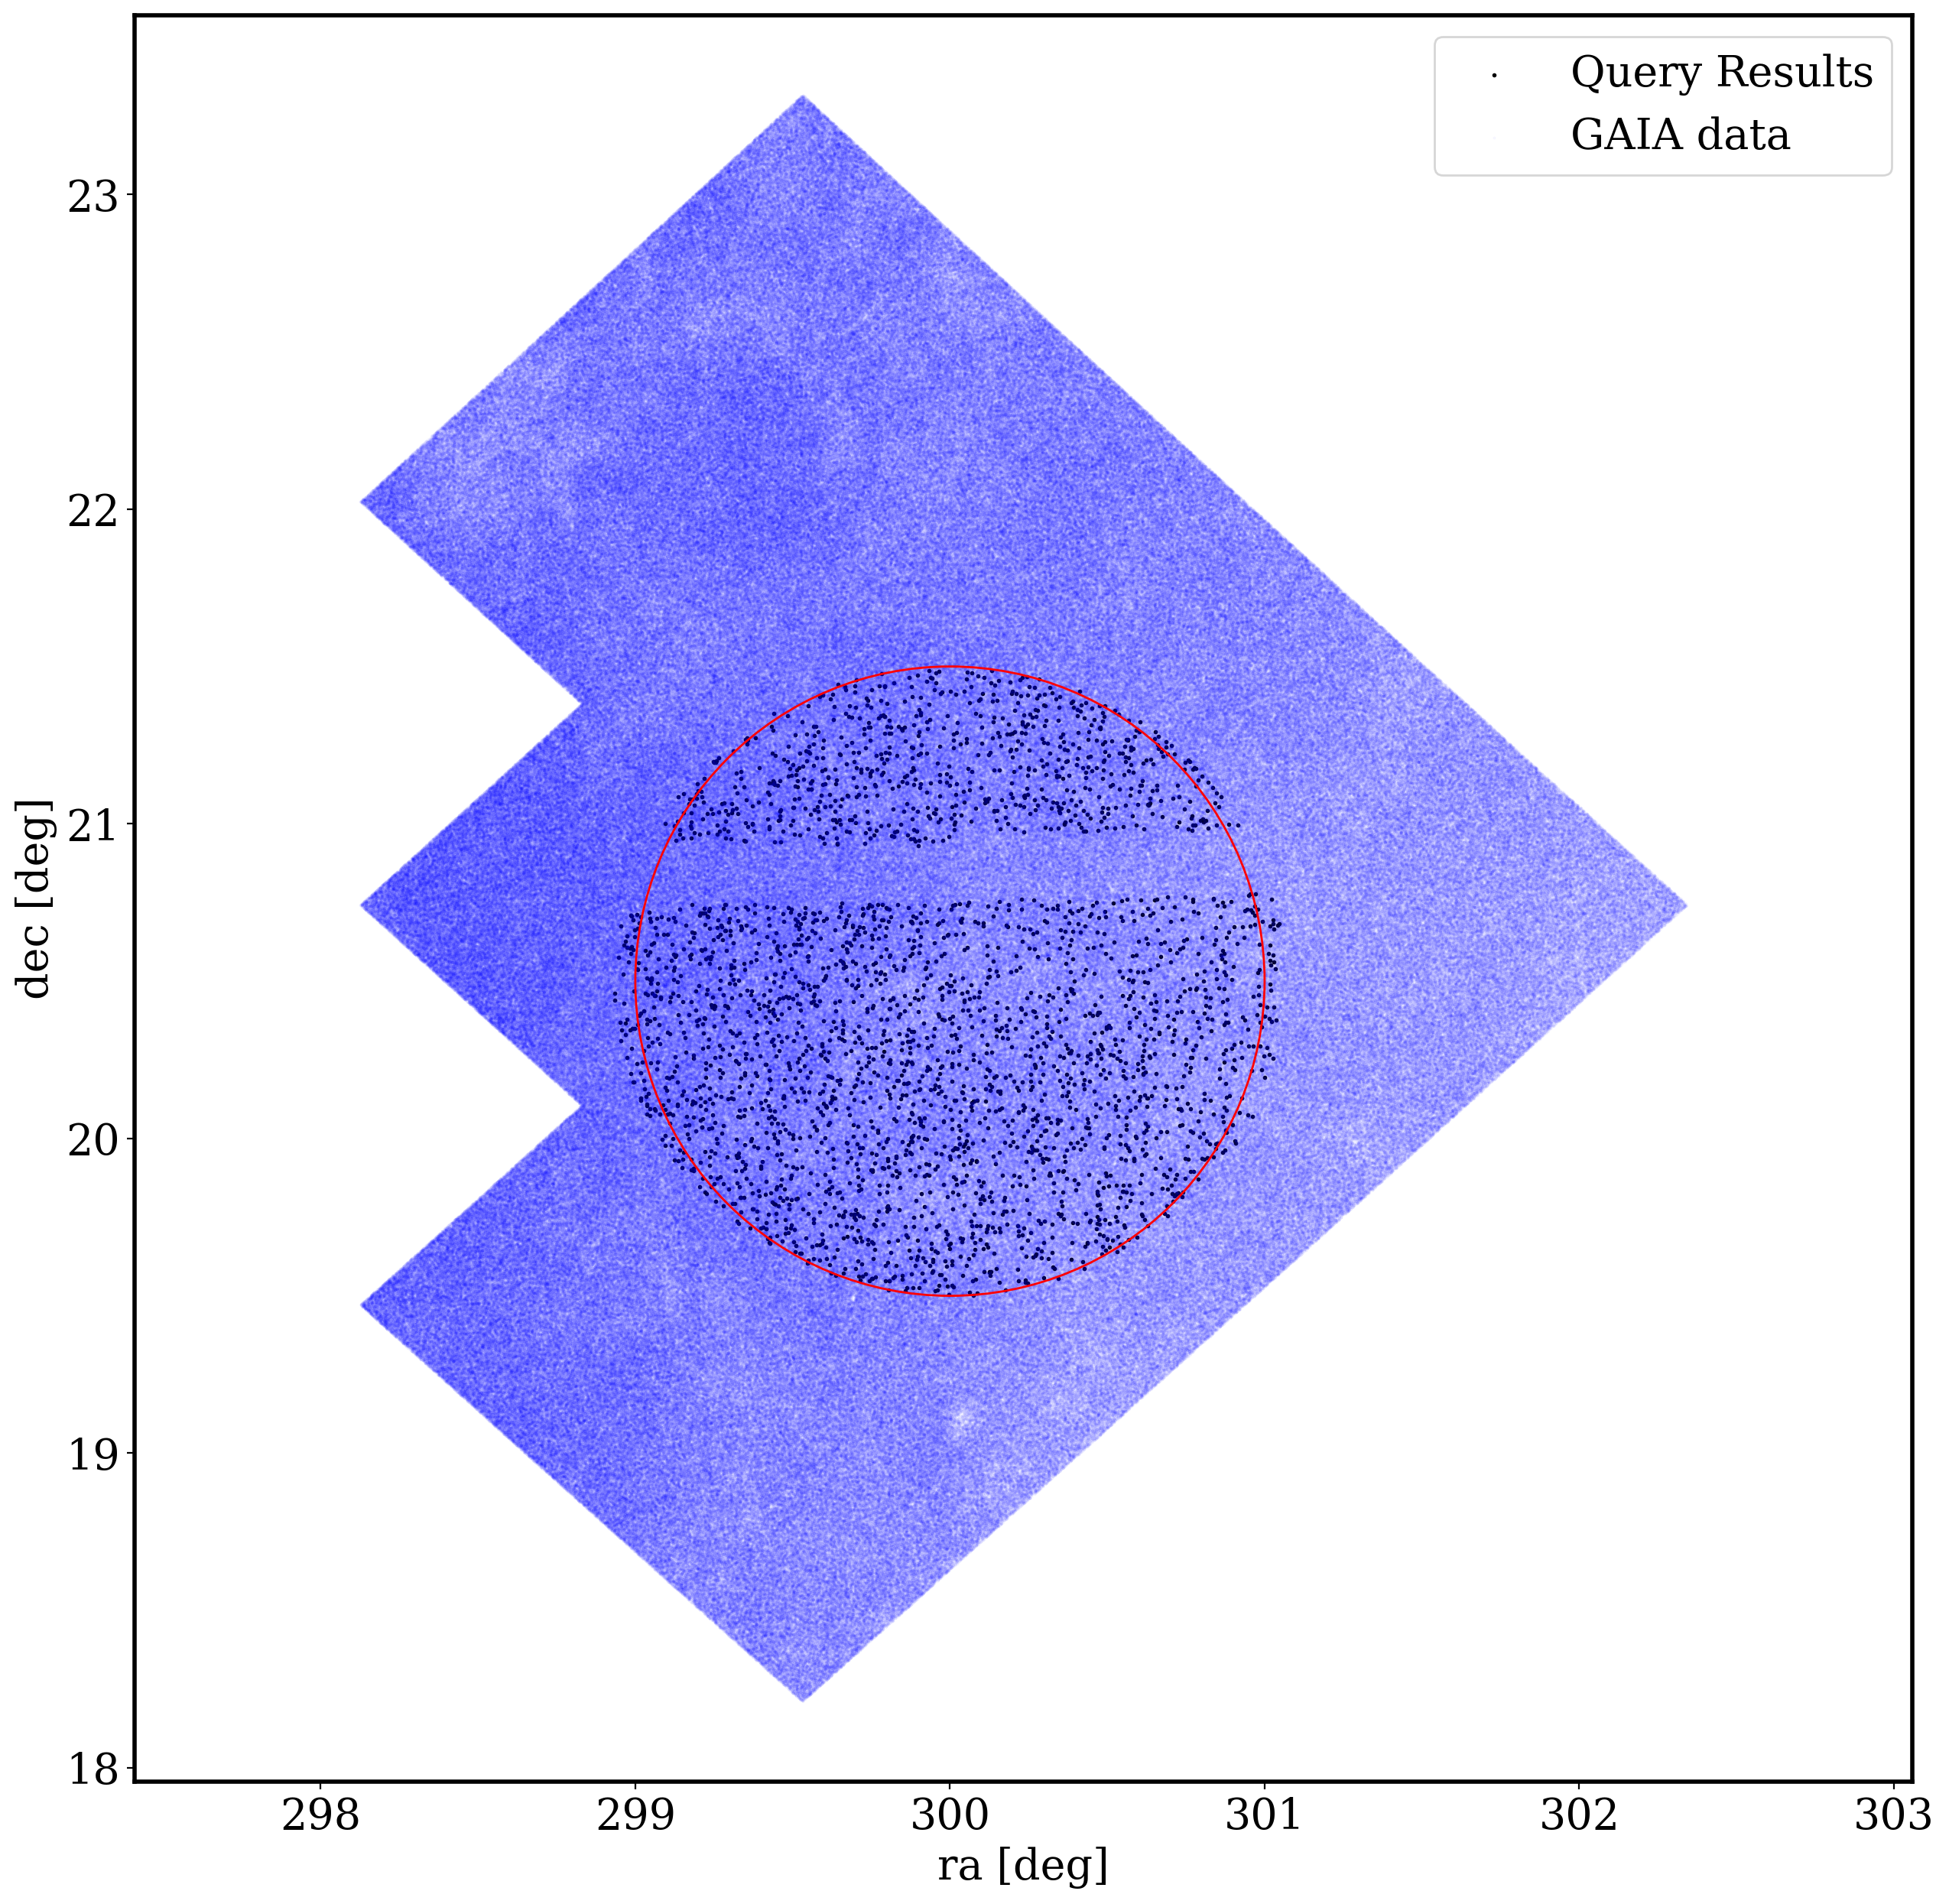

In [14]:
# Load a coarse version of Gaia DR3 (it has data from all the HEALPix intersecting with the cone)
cone_search = lsdb.core.search.ConeSearch(ra=-60, dec=20.5, radius_arcsec=1*3600)
gaia_patch_df = lsdb.read_hipscat(gaia_url, columns=["ra", "dec"], search_filter=cone_search).compute()

# Plot the figure
plt.figure(figsize=(15,15))
plt.scatter(df['ra_gaia'].values, df['dec_gaia'].values, color='black', s=1, label='Query Results')
plt.scatter(gaia_patch_df['ra'], gaia_patch_df['dec'], color='blue', s=0.1, alpha=0.05, label='GAIA data')

# Create a circle patch
circle = patches.Circle((300, 20.5), 1, edgecolor='red', facecolor='lightblue', fill=False)

plt.axis('equal')
plt.gca().add_patch(circle)
plt.xlabel('ra [deg]')
plt.ylabel('dec [deg]')
plt.legend()

Once when we finished the analysis we can export our results, in the hipscat catalog version. In order to do you would uncomment the line below. You can load them back via LSDB, or you can load these parquet files with any other parquet reader.

In [ ]:
# export crossmatched data to disk
# xobjects.to_hipscat(base_catalog_url="ztf_x_gaia", catalog_name="ztf_x_gaia", overwrite=True)

## Why is this interesting?

With this toolchain, we've allowed a non-specialist user to:
* Cone-search a 1TB-scale catalog
* On-the-fly cross-match the result with a 11TB-scale catalog
* Run a query filter over the result
* ... and visualize the output.

where the catalogs were remote, and the execution was transparently paralellized.

By removing the cross-match stanzas, the user could easily expand their analysis to the entire catalog. By pointing lsdb to run on a cluster (~few lines of boiler-plate code), this analysis could be done in a distributed fashion.

**This type of approach can enable large-scale, non-expert user, analytics on LSST-scale datasets.**